### Imports

In [2]:
import cv2
import time
import cProfile
import pstats

def f8(x):
    ret = "%8.3f" % x
    if ret != '   0.000':
        return ret
    return "%6dµs" % (x * 10000000)

pstats.f8 = f8

import ipywidgets as widgets
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from helpers.limbus_detection import detect_circle, detect_pupil_thresh
from helpers.misc import \
    jiggle_circle, tighten_circle, repair_bbox, is_circle_enclosed, geometric_median, \
    get_in_out_intensity_diff
from helpers.view_detection import get_view_mask

%load_ext autoreload
%autoreload 2

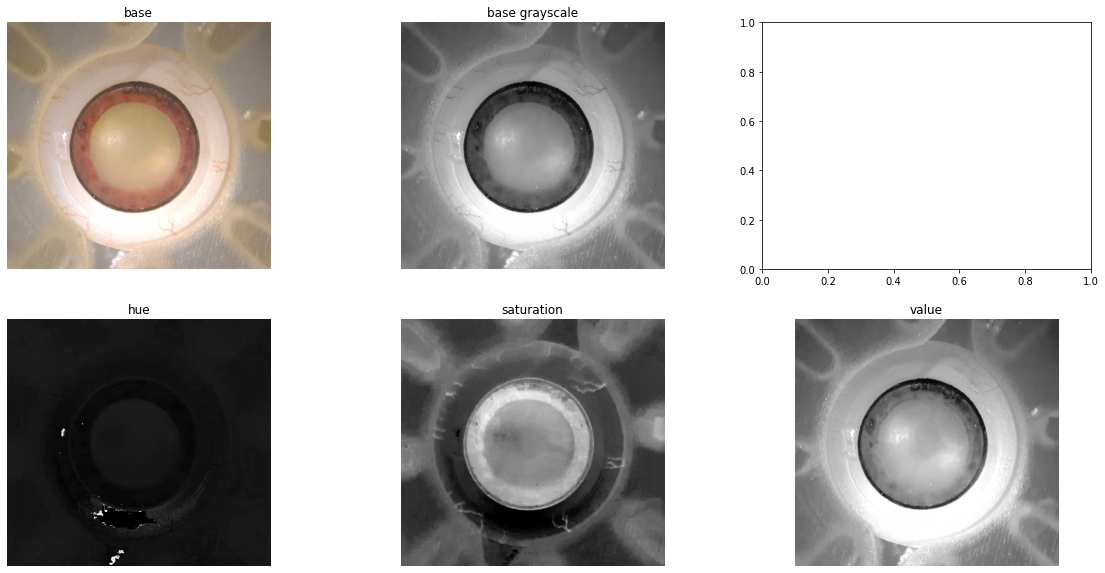

size: 640x601


In [3]:
scale = 0.33
# scale = 1.0

base = cv2.imread('data/artificial/base2.jpeg', cv2.IMREAD_COLOR)
base = cv2.resize(base, (0,0), fx=scale, fy=scale)

base_rgb = cv2.cvtColor(base, cv2.COLOR_BGR2RGB)
base_gray = cv2.cvtColor(base, cv2.COLOR_BGR2GRAY)
base_hsv = cv2.cvtColor(base, cv2.COLOR_BGR2HSV)

base_hue = base_hsv[:,:,0]
base_saturation = base_hsv[:,:,1]
base_value = base_hsv[:,:,2]

fig, ((plot1, plot2, _), (plot3, plot4, plot5)) = plt.subplots(2, 3, figsize=(20,10))
plot1.set_title('base')
plot1.imshow(base_rgb)
plot1.axis('off')

plot2.set_title('base grayscale')
plot2.imshow(base_gray, cmap=plt.cm.gray)
plot2.axis('off')

plot3.set_title('hue')
plot3.imshow(base_hue, cmap=plt.cm.gray)
plot3.axis('off')

plot4.set_title('saturation')
plot4.imshow(base_saturation, cmap=plt.cm.gray)
plot4.axis('off')

plot5.set_title('value')
plot5.imshow(base_value, cmap=plt.cm.gray)
plot5.axis('off')

plt.show()

print('size: %dx%d' % (base.shape[1], base.shape[0]))

#### detecting circles using Hough transform

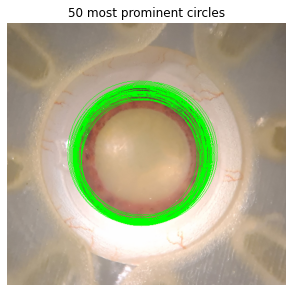

In [3]:
DRAW_CIRCLES = 50

circles = detect_circle(base_value, return_all=True)

base_rgb_copy = base_rgb.copy()
for circle in circles[:DRAW_CIRCLES]:
    cv2.circle(base_rgb_copy, (round(circle[0]), round(circle[1])), round(circle[2]), (0,255,0))
    
_, plot = plt.subplots(1, 1, figsize=(5,10))
plot.set_title('%d most prominent circles' % DRAW_CIRCLES)
plot.imshow(base_rgb_copy)
plot.axis('off')

plt.show()

#### analysis of in-out naive implementation

In [4]:
center = (round(circles[0,0]), round(circles[0,1]))
radius = round(circles[0,2])

profile = cProfile.Profile()
profile.runcall(get_in_out_intensity_diff, base_value, center, radius)
ps = pstats.Stats(profile)
ps.print_stats()

         30 function calls in 0.001 seconds

   Random listing order was used

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        2     15µs      7µs     15µs      7µs {built-in method builtins.hasattr}
        2     21µs     10µs     21µs     10µs {built-in method builtins.isinstance}
        2      5µs      2µs      5µs      2µs {built-in method builtins.issubclass}
        1      3µs      3µs      3µs      3µs {method 'disable' of '_lsprof.Profiler' objects}
        2   1521µs    760µs   1521µs    760µs {circle}
        2      9µs      4µs      9µs      4µs {built-in method numpy.asanyarray}
        2    201µs    100µs    201µs    100µs {built-in method numpy.zeros}
        2     30µs     15µs    870µs    435µs {built-in method numpy.core._multiarray_umath.implement_array_function}
        2     10µs      5µs     10µs      5µs {built-in method numpy.core._multiarray_umath.normalize_axis_index}
        2    279µs    139µs    279µs    139µs {method 'reduce

#### advanced indexing

In [5]:
a = np.array([[0,1,2],[3,4,5]])
indices = (np.array([0,0,1,0]), np.array([0,1,0,2]))
values = a[indices]

print('a:')
print(a)
print()

print('indices:')
print(indices)
print()

print('values:')
print(values)

a:
[[0 1 2]
 [3 4 5]]

indices:
(array([0, 0, 1, 0]), array([0, 1, 0, 2]))

values:
[0 1 3 2]


#### point sampling

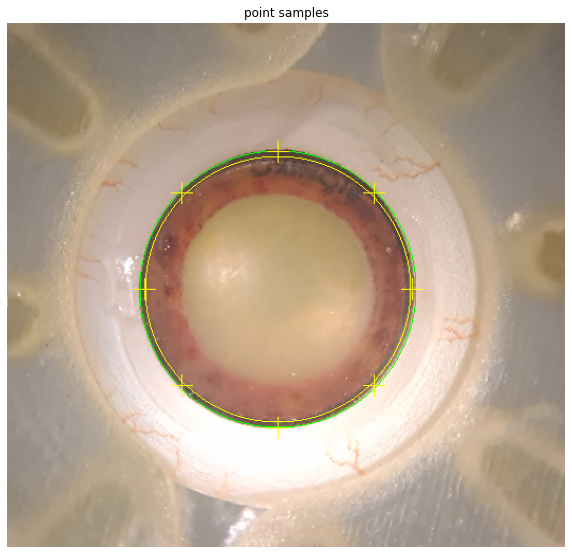

In [6]:
SAMPLED_POINTS = 8
CIRCLE_WIDTH_TO_RADIUS_RATIO = 0.04

correct_circle = circles[2]
center = (round(correct_circle[0]), round(correct_circle[1]))
radius = round(correct_circle[2])
circle_width = int(CIRCLE_WIDTH_TO_RADIUS_RATIO*radius)
    
xs_s = np.cos(2 * np.pi * np.arange(0, SAMPLED_POINTS, 1) / SAMPLED_POINTS)
ys_s = np.sin(2 * np.pi * np.arange(0, SAMPLED_POINTS, 1) / SAMPLED_POINTS)

scale = np.random.rand(SAMPLED_POINTS) * circle_width + radius - circle_width
xs_in = (xs_s * scale + center[0]).round().astype(np.int16)
ys_in = (ys_s * scale + center[1]).round().astype(np.int16)

base_rgb_copy = base_rgb.copy()
cv2.circle(base_rgb_copy, center, radius, (0,255,0))
cv2.circle(base_rgb_copy, center, radius - circle_width, (255,255,0))
for i in range(SAMPLED_POINTS):
    cv2.drawMarker(base_rgb_copy, (xs_in[i], ys_in[i]), (255,255,0))

_, plot = plt.subplots(1, 1, figsize=(10,10))
plot.set_title('point samples')
plot.imshow(base_rgb_copy)
plot.axis('off')

plt.show()

#### in-out difference using sampling

In [7]:
CIRCLE_WIDTH_TO_RADIUS_RATIO = 0.04
def get_in_out_intensity_diff_optim(grey, center, radius, sampled_points=8):
    assert isinstance(sampled_points, int) and sampled_points > 0, 'sampled_points must be a natural number'
    
    circle_width = int(CIRCLE_WIDTH_TO_RADIUS_RATIO*radius)
    
    xs_s = np.cos(2 * np.pi * np.arange(0, sampled_points, 1) / sampled_points)
    ys_s = np.sin(2 * np.pi * np.arange(0, sampled_points, 1) / sampled_points)
    
    scale = np.random.rand(sampled_points) * circle_width + radius - circle_width
    xs_in = (xs_s * scale + center[0]).round().astype(np.int16)
    ys_in = (ys_s * scale + center[1]).round().astype(np.int16)
    valid = np.logical_and.reduce((xs_in >= 0, ys_in >= 0, xs_in < grey.shape[1], ys_in < grey.shape[0]))
    in_intensity = np.mean(grey[(ys_in[valid], xs_in[valid])])
    
    scale = np.random.rand(sampled_points) * circle_width + radius
    xs_out = (xs_s * scale + center[0]).round().astype(np.int16)
    ys_out = (ys_s * scale + center[1]).round().astype(np.int16)
    valid = np.logical_and.reduce((xs_out >= 0, ys_out >= 0, xs_out < grey.shape[1], ys_out < grey.shape[0]))
    out_intensity = np.mean(grey[(ys_out[valid], xs_out[valid])])

    return out_intensity - in_intensity

#### analysis of precision

In [8]:
TRIALS = 1000
SAMPLED_POINTS_D = list(int(e) for e in 2**np.arange(1, 15, 1))

correct_circle = circles[2]
center = (round(correct_circle[0]), round(correct_circle[1]))
radius = round(correct_circle[2])

true_in_out = get_in_out_intensity_diff(base_value, center, radius)
print('true in-out: %f' % true_in_out)

sampled_points = []
optimized_in_outs = []
for sp in SAMPLED_POINTS_D:
    for _ in range(TRIALS):
        sampled_points.append(sp)
        optimized_in_outs.append(
            get_in_out_intensity_diff_optim(base_value, center, radius, sampled_points=sp))

df = pd.DataFrame({'sampled_points': sampled_points, 'in_out': optimized_in_outs})
df.groupby(['sampled_points'], as_index=False).agg({'in_out': ['mean', 'std']})

true in-out: 61.438954


sampled_points     in_out           
                        mean        std
0               2  78.847500  22.234137
1               4  88.155000  15.412094
2               8  88.384500  11.222092
3              16  84.548187   7.852250
4              32  86.439406   5.885822
5              64  87.059469   4.117767
6             128  87.493250   2.905680
7             256  87.058191   2.073155
8             512  87.223816   1.453161
9            1024  87.207447   1.022899
10           2048  87.255552   0.691497
11           4096  87.209516   0.540064
12           8192  87.225403   0.366934
13          16384  87.243753   0.268660

#### computation differences

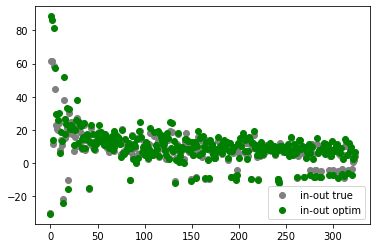

In [9]:
sampled_points = 128

in_out_true = []
in_out_optim = []
for circle in circles:
    center = (round(circle[0]), round(circle[1]))
    radius = round(circle[2])
    in_out_true.append(get_in_out_intensity_diff(base_value, center, radius))
    in_out_optim.append(get_in_out_intensity_diff_optim(
        base_value, center, radius, sampled_points=sampled_points))

in_out_true = np.array(in_out_true)
in_out_optim = np.array(in_out_optim)

plt.scatter(np.arange(0, len(in_out_true), 1), in_out_true, color='gray', label='in-out true')
plt.scatter(np.arange(0, len(in_out_optim), 1), in_out_optim, color='green', label='in-out optim')
plt.legend(loc='lower right')
plt.show()

#### performance analysis

In [10]:
center = (round(circles[0,0]), round(circles[0,1]))
radius = round(circles[0,2])

profile = cProfile.Profile()
profile.runcall(get_in_out_intensity_diff_optim, base_value, center, radius, 128)
ps = pstats.Stats(profile)
ps.print_stats()

         41 function calls in 0.000 seconds

   Random listing order was used

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        2     20µs     10µs     20µs     10µs {built-in method builtins.hasattr}
        3     12µs      4µs     12µs      4µs {built-in method builtins.isinstance}
        2      5µs      2µs      5µs      2µs {built-in method builtins.issubclass}
        1      4µs      4µs      4µs      4µs {method 'disable' of '_lsprof.Profiler' objects}
        4     83µs     20µs     83µs     20µs {method 'astype' of 'numpy.ndarray' objects}
        4     43µs     10µs     43µs     10µs {method 'round' of 'numpy.ndarray' objects}
        2      7µs      3µs      7µs      3µs {built-in method numpy.asanyarray}
        2    127µs     63µs    127µs     63µs {built-in method numpy.arange}
        2     34µs     17µs    707µs    353µs {built-in method numpy.core._multiarray_umath.implement_array_function}
        2     11µs      5µs     11µs      5µs {b

#### video demo

In [11]:
cap = cv2.VideoCapture('data/artificial/bioniko_input_long.mp4')
_, frame = cap.read()
view_mask, view_circle = get_view_mask(cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY), return_circle=True)

while cap.isOpened():
    ret, frame = cap.read() 

    # performance measurement
    timer = cv2.getTickCount()
    
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV) 
    value = hsv[:,:,2]
    
    # fetching all circles
    circles = detect_circle(value, return_all=True)
    if circles is not None:
        circles = circles[:int(0.05*len(circles))]
        
        # in-out methods
        true_in_outs = []
        optim_in_outs = []
        for circle in circles:
            center = (round(correct_circle[0]), round(correct_circle[1]))
            radius = round(correct_circle[2])
            true_in_outs.append(get_in_out_intensity_diff(value, center, radius))
            optim_in_outs.append(get_in_out_intensity_diff_optim(value, center, radius, sampled_points=128))

        # visualizations
        true_circle = circles[np.argmax(true_in_out)]
        cv2.circle(frame, (round(true_circle[0]), round(true_circle[1])), round(true_circle[2]), (0,255,0))

        optim_circle = circles[np.argmax(optim_in_outs)]
        cv2.circle(frame, (round(optim_circle[0]), round(optim_circle[1])), round(optim_circle[2]), (0,255,255))

    fps = cv2.getTickFrequency() / (cv2.getTickCount() - timer)
    
    cv2.imshow('original', frame)

    if cv2.waitKey(25) == ord('q'): 
        break

cap.release() 
for _ in range(10):
    cv2.destroyAllWindows()
    cv2.waitKey(1)

(640, 360)

In [262]:
cap = cv2.VideoCapture('data/artificial/bioniko_input_long.mp4')
_, frame = cap.read()
view_mask, view_circle = get_view_mask(cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY), return_circle=True)

while cap.isOpened():
    ret, frame = cap.read() 

    # performance measurement
    timer = cv2.getTickCount()
    
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV) 
    value = hsv[:,:,2]
    
    # fetching all circles
    circle = detect_circle(value, validation='inout', considered_ratio_s=0.1)
    
    if circle is not None:
        cv2.circle(frame, (round(circle[0]), round(circle[1])), round(circle[2]), (0,255,0))
    
    fps = cv2.getTickFrequency() / (cv2.getTickCount() - timer)
    
    cv2.imshow('original', frame)

    if cv2.waitKey(25) == ord('q'): 
        break

cap.release() 
for _ in range(10):
    cv2.destroyAllWindows()
    cv2.waitKey(1)